In [220]:
from create_model import get_model
from dataset import load_data
from evaluate import evaluate_batch
from train_model import collate_fn
from visualization import visualize_one_image, drawrect
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import nms
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

In [3]:
# Load Model
model = get_model("fasterrcnn", num_classes=4, trainable_backbone_layers=1)
model_path = "C://Users//zente//Downloads//model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

Total params: 41309411
Total trainable params: 32796707


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
# Load dataset
dataset_path = "./../../NBA-Player-Detector-1"
trainset, valset, testset = load_data(dataset_path)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=2, 
                                          shuffle=False, 
                                          num_workers=1, 
                                          drop_last=True,
                                          collate_fn = collate_fn)

In [229]:
for (images, labels) in trainloader:
    predictions = model(images)
    N = len(images)
    for i in range(N):
        image = images[i]
        label = labels[i]
        pred = predictions[i]
    break

In [237]:
print(pred)

{'boxes': tensor([[ 766.8655,  567.6176,  948.4456,  784.1437],
        [1422.6740,  592.2396, 1517.1361,  809.7186],
        [ 600.3397,  631.4373,  720.8724,  836.8479],
        [ 411.4799,  605.1877,  507.3152,  860.9588],
        [ 143.3743,  369.8061,  266.7348,  550.3864],
        [ 670.7487,  405.5292,  727.0596,  626.0507],
        [ 928.3751,  362.0586, 1027.0845,  558.2775],
        [1701.6580,  664.5883, 1821.9446,  866.9966],
        [ 497.0606,  594.9243,  579.5941,  754.8358],
        [1409.7115,  150.2044, 1543.9598,  398.8844],
        [1002.2007,  782.1644, 1126.8278,  992.0245],
        [ 424.3572,  592.1325,  560.6207,  805.2416],
        [1439.5707,  182.7401, 1518.1536,  366.8448],
        [1483.1361,  368.0091, 1539.1315,  537.8799],
        [ 696.3329,  681.7953,  728.7103,  712.7603],
        [1350.6444,  170.4350, 1514.2246,  388.2293],
        [1421.2909,  192.5744, 1584.3787,  344.1349],
        [ 691.1656,  680.1128,  729.0142,  716.0437],
        [ 675.7946

In [86]:
# Remove the 'scores' key from pred
pred_scores = pred["scores"]
pred.pop("scores")

tensor([0.9899, 0.9884, 0.9785, 0.9649, 0.9598, 0.9454, 0.9396, 0.9098, 0.7487,
        0.5952, 0.5917, 0.5203, 0.5085, 0.4034, 0.3820, 0.2961, 0.2923, 0.2879,
        0.2857, 0.2318, 0.2088, 0.1735, 0.1671, 0.1505, 0.1502, 0.1453, 0.1254,
        0.1224, 0.1155, 0.1056, 0.1042, 0.1039, 0.0971, 0.0918, 0.0853, 0.0844,
        0.0742, 0.0725, 0.0702, 0.0669, 0.0668, 0.0664, 0.0642, 0.0593, 0.0588,
        0.0567, 0.0564, 0.0554, 0.0546, 0.0538, 0.0529],
       grad_fn=<IndexBackward0>)

In [116]:
print(pred.keys())
print(pred['boxes'].shape)
print(label.keys())
print(label['boxes'].shape)

CLASS_COLORS = {
    1 : (255,0,0),
    2 : (0,255,0),
    3 : (0,0,255)
}

colors_gt = [CLASS_COLORS[label_id.item()] for label_id in label['labels']]
colors_pred = [CLASS_COLORS[label_id.item()] for label_id in pred['labels']]

dict_keys(['boxes', 'labels'])
torch.Size([51, 4])
dict_keys(['boxes', 'labels'])
torch.Size([12, 4])


In [217]:
print(image.dtype)
print(image.shape)

torch.float32
torch.Size([3, 1080, 1920])


<class 'torch.Tensor'>
torch.Size([3, 1080, 1920])


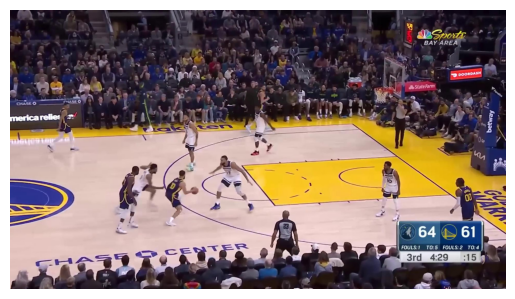

In [178]:
image_uint8 = (image * 255).to(torch.uint8)
print(type(image_uint8))
print(image_uint8.shape)
vis_image = image_uint8.permute(1,2,0).numpy()
plt.imshow(vis_image)
plt.axis('off')
plt.show()

In [223]:
pred["boxes"]
keep = nms(pred['boxes'], pred_scores, 0.3)
print(keep)
print(pred_scores[keep])


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 24, 26, 30, 47, 50])
tensor([0.9899, 0.9884, 0.9785, 0.9649, 0.9598, 0.9454, 0.9396, 0.9098, 0.7487,
        0.5952, 0.5917, 0.4034, 0.3820, 0.1502, 0.1254, 0.1042, 0.0554, 0.0529],
       grad_fn=<IndexBackward0>)


In [233]:
pred['boxes'][9]

tensor([1409.7115,  150.2044, 1543.9598,  398.8844], grad_fn=<SelectBackward0>)

(-0.5, 1919.5, 1079.5, -0.5)

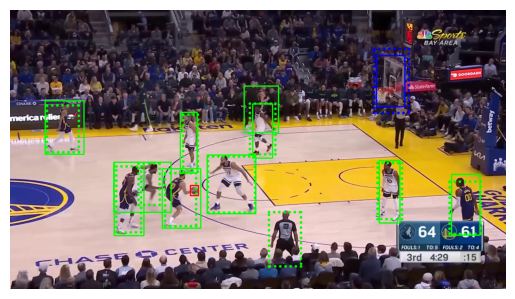

In [181]:
# Now draw the predictions
vis_image = image_uint8.permute(1,2,0).numpy()
MIN_SCORE_TO_PLOT = 0.55
for i in range(len(pred["boxes"])):
    if pred_scores[i] >= MIN_SCORE_TO_PLOT:
        box = pred["boxes"][i] # this is a Tensor(4)
        x_min, y_min, x_max, y_max = box
        point1 = (int(x_min), int(y_min))
        point2 = (int(x_max), int(y_max))
        color = colors_pred[i]
        #vis_image = cv2.rectangle(vis_image, point1, point2, color, thickness=4, lineType=cv2.LINE_AA)
        drawrect(vis_image, point1, point2, color, thickness=5, style='dotted')

# Now draw the gt
for i in range(len(label["boxes"])):
    box = label["boxes"][i]
    x_min, y_min, x_max, y_max = box
    point1 = (int(x_min), int(y_min))
    point2 = (int(x_max), int(y_max))
    color = colors_gt[i]
    vis_image = cv2.rectangle(vis_image, point1, point2, color, thickness=4)

plt.imshow(vis_image)
plt.axis('off')

In [206]:
def calculate_iou(box1: list, box2: list) -> float:
    """Calculates IOU between 2 boxes

    Args:
        box1 (list): [x_min, y_min, x_max, y_max]
        box2 (list): [x_min, y_min, x_max, y_max]

    Returns:
        iou (float):
    """
    assert type(box1) == list
    assert type(box2) == list
    assert len(box1) == 4
    assert len(box2) == 4

    # Calculate the intersection coordinates
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    # Calculate the intersection area
    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    #print(f"intersection_area: {intersection_area}")

    # Calculate the union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    #print(f"union_area: {union_area}")

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

# Unit test: [x_min, y_min, x_max, y_max]
box1 = [0,0,5,6]
box2 = [1,3,7,8]
print(f"IOU should be 0.25: {calculate_iou(box1, box2)}")
box1 = [0,0,5,6]
box2 = [5,3,7,8]
print(f"IOU should be 0: {calculate_iou(box1, box2)}")
box1 = [0,0,5,6]
box2 = [-10,3,0,8]
print(f"IOU should be 0: {calculate_iou(box1, box2)}")
del box1, box2

IOU should be 0.25: 0.25
IOU should be 0: 0.0
IOU should be 0: 0.0


In [201]:
label_boxes = label['boxes']
print(label_boxes.shape)
test_list = label_boxes.detach().clone().tolist()
for x in test_list:
    print(x)
print(label_boxes.shape[1])

torch.Size([12, 4])
[136.0, 351.0, 286.0, 558.0]
[403.0, 589.0, 518.0, 873.0]
[401.0, 589.0, 623.0, 783.0]
[589.0, 614.0, 738.0, 844.0]
[763.0, 561.0, 951.0, 788.0]
[659.0, 396.0, 724.0, 631.0]
[939.0, 363.0, 1016.0, 573.0]
[906.0, 294.0, 1039.0, 474.0]
[1429.0, 583.0, 1509.0, 824.0]
[1709.0, 636.0, 1819.0, 871.0]
[1418.0, 176.0, 1528.0, 374.0]
[698.0, 679.0, 729.0, 718.0]
4


In [210]:
def calculate_tp_tn_fp_fn(gt_boxes: torch.Tensor, pred_boxes: torch.Tensor, iou_threshold=0.5):
    """Calculates TP, TN, FP, FN

    Args:
        gt_boxes (torch.Tensor): (N,4)
        pred_boxes (torch.Tensor): (M,4)
        iou_threshold (float, optional): Defaults to 0.5.

    Returns:
        TP, TN, FP, FN: ints
    """

    assert type(gt_boxes) == torch.Tensor
    assert type(pred_boxes) == torch.Tensor
    assert len(gt_boxes.shape) == 2 # this is 2D
    assert len(pred_boxes.shape) == 2 # this is 2D
    assert gt_boxes.shape[1] == 4 # 4 columns
    assert pred_boxes.shape[1] == 4 # 4 columns

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    # Create a copy of the original data to lists
    gt_box_list = gt_boxes.detach().clone().tolist()
    pr_box_list = pred_boxes.detach().clone().tolist()

    # Iterate through each predicted box
    for pred_box in pr_box_list:
        max_iou = 0
        max_iou_index = -1

        # Find the ground truth box with the highest IoU
        for i, gt_box in enumerate(gt_box_list):
            iou = calculate_iou(pred_box, gt_box)
            if iou > max_iou:
                max_iou = iou
                max_iou_index = i

        # Check if the highest IoU is above the threshold
        if max_iou >= iou_threshold:
            tp += 1
            # Remove the matched ground truth box
            gt_box_list.pop(max_iou_index)
        else:
            fp += 1

    # Any remaining ground truth boxes are false negatives
    fn = len(gt_box_list)

    # Calculate true negatives
    tn = 0

    return tp, tn, fp, fn

# Unit test
print(calculate_tp_tn_fp_fn(label['boxes'], pred["boxes"][pred_scores > 0.55]))

(9, 0, 2, 3)
